In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import random
import functions
import hybrid_ann
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('beer.csv')
data = df.iloc[:, -1].values

serie_normal = functions.normalizar_serie(data)
serie_lags = functions.gerar_janelas(tam_janela = 5, serie = serie_normal)
X_train, y_train, X_test, y_test = functions.split_serie_with_lags(serie = serie_lags, perc_train = 0.8, perc_val = 0)

In [3]:
model = hybrid_ann.LNL_ANN(m = 5)

model.fit_MPSO(X = X_train, y = y_train, d= 30, c1i = 1.0, c1f = 2.0, c2i = 1.0, c2f = 2.0, w1 = 0.5, w2 = 1.0, maxt = 1000)
y_pred = model.predict(X_test)
# print('Prediction:', y_pred)
# print('Test:', y_test)

# Análise de Dados

## Conjunto de treinamento

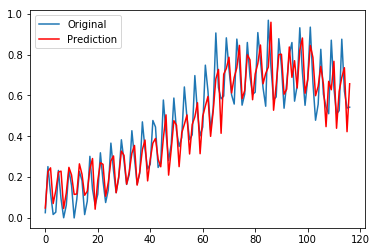

In [4]:
y_train_pred = model.predict(X_train)
plt.plot(y_train, label = 'Original')
plt.plot(y_train_pred, label = 'Prediction', color = 'red')
plt.legend()

## Test Data

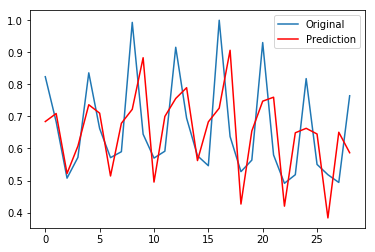

In [5]:
plt.plot(y_test, label = 'Original')
plt.plot(y_pred, label = 'Prediction', color = 'red')
plt.legend()

## Comparação entre os modelos

In [6]:
Forecasts = pd.DataFrame(
{
'Test data': y_test,
'SARIMA': y_test,
'WMES': y_test,
'FFANN': y_test,
'RBF': y_test,
'L&NL-ANN': y_pred
}
)

Metrics = pd.DataFrame(
{
'SARIMA': [functions.RMSE(y_test, y_pred), functions.MAPE(y_test, y_pred), functions.MdAPE(y_test, y_pred), functions.DA(y_test, y_pred)],
'WMES': [functions.RMSE(y_test, y_pred), functions.MAPE(y_test, y_pred), functions.MdAPE(y_test, y_pred), functions.DA(y_test, y_pred)],
'FFANN': [functions.RMSE(y_test, y_pred), functions.MAPE(y_test, y_pred), functions.MdAPE(y_test, y_pred), functions.DA(y_test, y_pred)],
'RBF': [functions.RMSE(y_test, y_pred), functions.MAPE(y_test, y_pred), functions.MdAPE(y_test, y_pred), functions.DA(y_test, y_pred)],
'L&NL-ANN': [functions.RMSE(y_test, y_pred), functions.MAPE(y_test, y_pred), functions.MdAPE(y_test, y_pred), functions.DA(y_test, y_pred)],
}, index = ['RMSE', 'MAPE', 'MdAPE', 'DA']
)

#Falta criar os outros modelos e inserir os respectivos conjuntos de previsão em cada função de erro.

In [7]:
Forecasts.head()

,Test data,SARIMA,WMES,FFANN,RBF,L&NL-ANN
0,0.823829,0.823829,0.823829,0.823829,0.823829,0.683956
1,0.683266,0.683266,0.683266,0.683266,0.683266,0.709024
2,0.507363,0.507363,0.507363,0.507363,0.507363,0.521789
3,0.572155,0.572155,0.572155,0.572155,0.572155,0.607359
4,0.835877,0.835877,0.835877,0.835877,0.835877,0.736364


In [8]:
Metrics

,SARIMA,WMES,FFANN,RBF,L&NL-ANN
RMSE,0.144783,0.144783,0.144783,0.144783,0.144783
MAPE,0.186606,0.186606,0.186606,0.186606,0.186606
MdAPE,0.174423,0.174423,0.174423,0.174423,0.174423
DA,0.928571,0.928571,0.928571,0.928571,0.928571


# Erro da série

In [9]:
resid_train = functions._error(y_train, y_train_pred)
resid_test = functions._error(y_test, y_pred)

In [10]:
resid_train_lags = functions.gerar_janelas(tam_janela = 2, serie = resid_train)
resid_test_lags = functions.gerar_janelas(tam_janela = 2, serie = resid_test)

In [11]:
#Treinamento
X_error_train = resid_train_lags[:, :-1]
y_error_train = resid_train_lags[:, -1]

#Teste
X_error_test = resid_test_lags[:, :-1]
y_error_test = resid_test_lags[:, -1]

# Modelo Proposto 1:

<img src="model1.png">

In [12]:
model_resid = hybrid_ann.LNL_ANN(m = 2)
model_resid.fit_MPSO(X = X_error_train, y = y_error_train, d= 20, c1i = 1.0, c1f = 2.0, c2i = 1.0, c2f = 2.0, w1 = 0.2, w2 = 0.8, maxt = 1000)

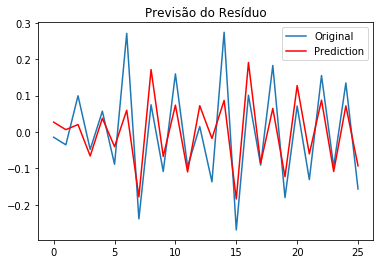

In [13]:
resid_pred = model_resid.predict(X_error_test)
plt.plot(y_error_test, label = 'Original')
plt.plot(resid_pred, label = 'Prediction', color = 'red')
plt.title('Previsão do Resíduo')
plt.legend()

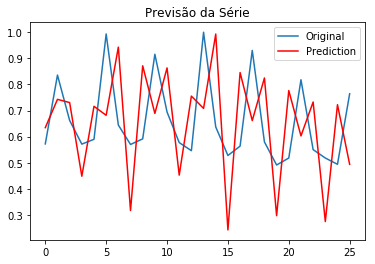

In [14]:
plt.plot(y_test[3:], label = 'Original')
plt.plot(y_pred[3:] + resid_pred, label = 'Prediction', color = 'red')
plt.title('Previsão da Série')
plt.legend()

# Modelo Proposto 2:

<img src="model2.png">

In [15]:
X_train_e = np.hstack((X_train[1:, :], resid_train[:-1].reshape(-1, 1)))
X_test_e = np.hstack((X_test[1:, :], resid_test[:-1].reshape(-1,1)))

In [16]:
model2 = hybrid_ann.Hybrid_ANN(model.weight)

model2.fit_MPSO(X = X_train_e, y = y_train[1:], d= 30, c1i = 1.0, c1f = 2.0, c2i = 1.0, c2f = 2.0, w1 = 0.5, w2 = 1.0, maxt = 1000)
y_pred2 = model2.predict(X_test_e)

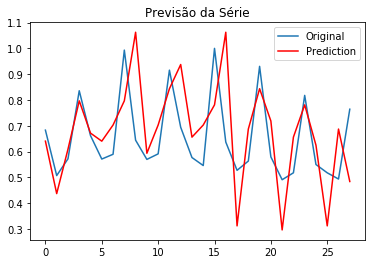

In [17]:
plt.plot(y_test[1:], label = 'Original')
plt.plot(y_pred2 , label = 'Prediction', color = 'red')
plt.title('Previsão da Série')
plt.legend()

# Resultados

In [18]:
Metrics = pd.DataFrame(
{
'RMSE': [functions.RMSE(y_test, y_pred), functions.RMSE(y_test[3:], y_pred[3:] + resid_pred), functions.RMSE(y_test[1:], y_pred2)],
'MAPE': [functions.MAPE(y_test, y_pred), functions.MAPE(y_test[3:], y_pred[3:] + resid_pred),functions.MAPE(y_test[1:], y_pred2)],
'MdAPE': [functions.MdAPE(y_test, y_pred), functions.MdAPE(y_test[3:], y_pred[3:] + resid_pred),functions.MdAPE(y_test[1:], y_pred2)],
'DA': [functions.DA(y_test, y_pred), functions.DA(y_test[3:], y_pred[3:] + resid_pred),functions.DA(y_test[1:], y_pred2)]
}, index = ['L&NL-ANN', 'L&NL-ANN Modified 1', 'L&NL-ANN Modified 2']
)

Metrics

,RMSE,MAPE,MdAPE,DA
L&NL-ANN,0.144783,0.186606,0.174423,0.928571
L&NL-ANN Modified 1,0.231209,0.342887,0.342905,0.880000
L&NL-ANN Modified 2,0.178087,0.229091,0.194922,0.777778
